```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# 财富分布动态

```{contents} 目录
:depth: 2
```

```{seealso}
本讲座的`GPU`版本可在[这里](https://jax.quantecon.org/wealth_dynamics.html)找到
```

除了Anaconda中已有的库外，本讲座还需要以下库：

In [1]:
!pip install quantecon

## 概述

本课程介绍了财富分布动态，在本讲中，我们

* 通过模拟建模和计算财富分布，
* 介绍不平等的衡量指标，如洛伦兹曲线和基尼系数
* 以及探究工资收入和资产回报的特性如何影响不平等。

我们这里讨论的财富分布，有一个有趣的特性是帕累托尾。

许多国家的财富分布都表现出帕累托尾

* 参见{doc}`本讲座<intro:heavy_tails>`中的定义。
* 关于相关实证证据的综述，请参见{cite}`benhabib2018skewed`。

这与现实中，财富高度集中在最富有的一部分家庭的情况一致。

这一特性也为我们提供了一种量化这种集中度的方法：通过尾部指数。

一个值得关注的问题是，我们是否能从一个相对简单的模型中复现出帕累托尾部。

### 关于假设的说明

任何给定家庭的财富变动取决于其储蓄行为。

对这种储蓄行为的建模将成为本系列讲座的要点。

然而，在本次讲座中，我们假设相对简单（但合理）的储蓄规则就足够。

我们这样做是为了探索不同收入动态和投资回报规格的影响。

同时，这里讨论的所有技术都可以应用到基于优化来获得储蓄规则的模型中。

我们将使用以下导入。

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

plt.rcParams["figure.figsize"] = (11, 5)  # 设置默认图形大小
import numpy as np
import quantecon as qe
from numba import jit, float64, prange
from numba.experimental import jitclass

## 洛伦兹曲线和基尼系数

在研究财富动态之前，我们先简要回顾一下一些不平等的衡量指标。

### 洛伦兹曲线

[洛伦兹曲线](https://en.wikipedia.org/wiki/Lorenz_curve)是一种广受欢迎的不平等图形度量方法。

上面已经导入的[QuantEcon.py](https://github.com/QuantEcon/QuantEcon.py)包含了计算洛伦兹曲线的函数。

举例说明，假设以下数据代表了10,000个家庭的财富分布

In [3]:
n = 10_000                      # 样本大小
w = np.exp(np.random.randn(n))  # 生成对数正态分布的随机样本

我们可以按如下方式计算并绘制洛伦兹曲线：

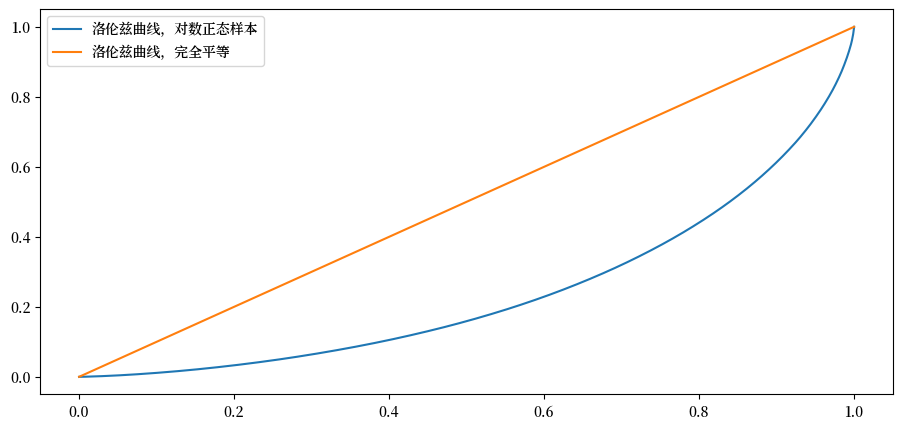

In [4]:
f_vals, l_vals = qe.lorenz_curve(w)

fig, ax = plt.subplots()
ax.plot(f_vals, l_vals, label='洛伦兹曲线，对数正态样本')
ax.plot(f_vals, f_vals, label='洛伦兹曲线，完全平等')
ax.legend()
plt.show()

这条曲线可以这样理解：如果点$(x,y)$位于曲线上，这意味着最底层$(100x)\%$的人口拥有$(100y)\%$的财富。

"平等"线是45度线（在图中可能不完全是45度，这取决于图形的纵横比）。

产生这条线的样本表现出完全平等。

图中的另一条线是对数正态样本的洛伦兹曲线，它与完全平等线有显著偏离。

例如，最底层80%的人口拥有大约40%的总财富。

这里有另一个例子，展示了当底层分布发生变化时洛伦兹曲线如何移动。

我们使用帕累托分布和一系列参数生成10,000个观测值，然后计算对应于每组观测值的洛伦兹曲线。

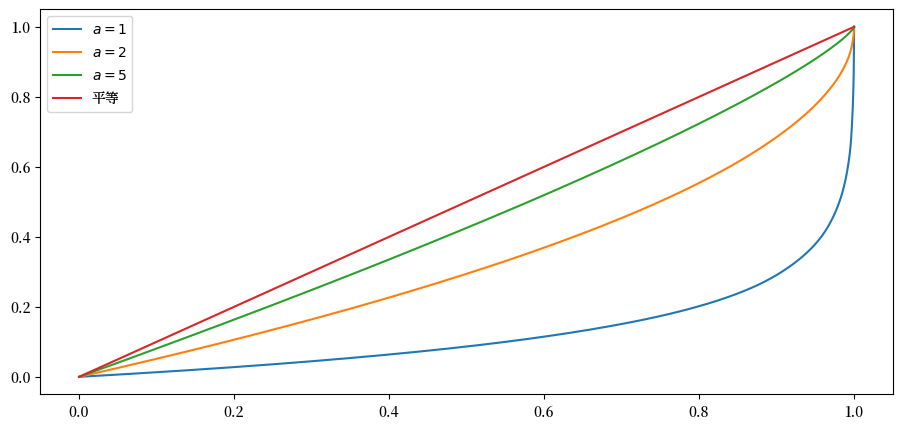

In [5]:
a_vals = (1, 2, 5)              # 帕累托分布的尾部指数
n = 10_000                      # 每个样本的大小
fig, ax = plt.subplots()
for a in a_vals:
    u = np.random.uniform(size=n)
    y = u**(-1/a)               # 服从尾部指数为a的帕累托分布
    f_vals, l_vals = qe.lorenz_curve(y)
    ax.plot(f_vals, l_vals, label=f'$a = {a}$')
ax.plot(f_vals, f_vals, label='平等')
ax.legend()
plt.show()

你可以看到，随着帕累托分布的尾部参数增加，不平等程度降低。

这是可以预料的，因为更高的尾部指数意味着帕累托分布尾部的权重更小。

### 基尼系数

基尼系数的定义和解释可以在相应的[百科页面](https://baike.baidu.com/item/%E5%9F%BA%E5%B0%BC%E7%B3%BB%E6%95%B0/88365)上找到。

0值表示完全平等（对应洛伦兹曲线与45度线重合的情况），1值表示完全不平等（所有财富都由最富有的家庭持有）。

[QuantEcon.py](https://github.com/QuantEcon/QuantEcon.py)库包含一个计算基尼系数的函数。

我们可以在参数为$a$的韦伯分布上测试它，其基尼系数已知为

$$
G = 1 - 2^{-1/a}
$$

让我们看看从模拟样本计算出的基尼系数是否在每个固定的$a$值处都与理论值相匹配。

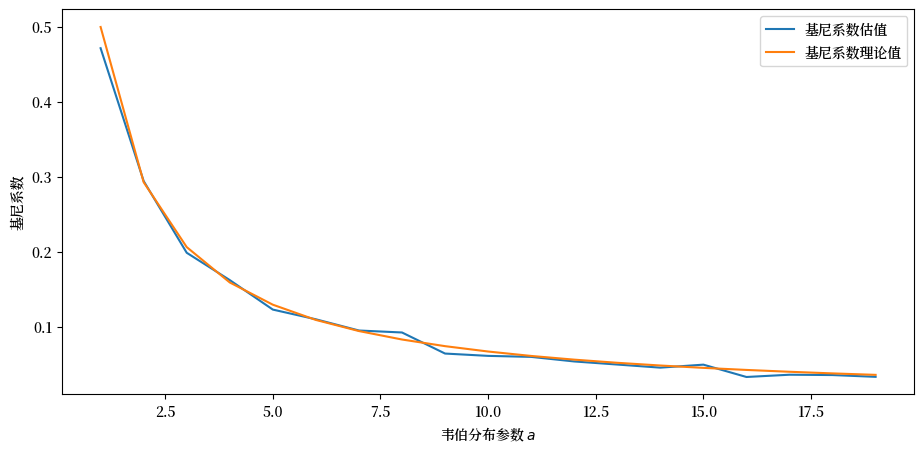

In [6]:
a_vals = range(1, 20)
ginis = []
ginis_theoretical = []
n = 100

fig, ax = plt.subplots()
for a in a_vals:
    y = np.random.weibull(a, size=n)
    ginis.append(qe.gini_coefficient(y))
    ginis_theoretical.append(1 - 2**(-1/a))
ax.plot(a_vals, ginis, label='基尼系数估值')
ax.plot(a_vals, ginis_theoretical, label='基尼系数理论值')
ax.legend()
ax.set_xlabel("韦伯分布参数 $a$")
ax.set_ylabel("基尼系数")
plt.show()

模拟结果显示拟合效果良好。

## 财富动态模型

在讨论了不平等的度量方法后，我们转向财富动态。

我们要研究的模型是

```{math}
:label: wealth_dynam_ah

w_{t+1} = (1 + r_{t+1}) s(w_t) + y_{t+1}
```

其中

- $w_t$ 是某个家庭在t时刻持有的财富，
- $r_t$ 是金融资产t时刻的收益率，
- $y_t$ 是当前非金融（如，劳动）收入，
- $s(w_t)$ 是当前财富减去消费后的净值

令 $\{z_t\}$ 为具有以下形式的相关状态过程：

$$
z_{t+1} = a z_t + b + \sigma_z \epsilon_{t+1}
$$

我们假设：

$$
R_t := 1 + r_t = c_r \exp(z_t) + \exp(\mu_r + \sigma_r \xi_t)
$$

且

$$
y_t = c_y \exp(z_t) + \exp(\mu_y + \sigma_y \zeta_t)
$$

这里 $\{ (\epsilon_t, \xi_t, \zeta_t) \}$ 是在 $\mathbb R^3$ 中的独立同分布标准正态分布。

$c_r$ 的值应该接近于零，因为资产收益率不会表现出较大的趋势。

当我们模拟家庭人口时，我们假设所有冲击都是特质的（即，特定于个别家庭且彼此之间相互独立）。

关于储蓄函数$s$，我们的默认模型将是

```{math}
:label: sav_ah

s(w) = s_0 w \cdot \mathbb 1\{w \geq \hat w\}
```

其中$s_0$是一个正常数。

因此，当$w < \hat w$时，家庭不进行任何储蓄。当$w \geq \bar w$时，家庭会储蓄其财富的$s_0$比例。

我们使用的是类似于固定储蓄率的模型，同时认识到低财富家庭往往很少储蓄。

## 实现

这里是一些帮助Numba的类型信息。

In [7]:
wealth_dynamics_data = [
    ('w_hat',  float64),    # 储蓄参数
    ('s_0',    float64),    # 储蓄参数
    ('c_y',    float64),    # 劳动收入参数
    ('μ_y',    float64),    # 劳动收入参数
    ('σ_y',    float64),    # 劳动收入参数
    ('c_r',    float64),    # 回报率参数
    ('μ_r',    float64),    # 回报率参数
    ('σ_r',    float64),    # 回报率参数
    ('a',      float64),    # 总体冲击参数
    ('b',      float64),    # 总体冲击参数
    ('σ_z',    float64),    # 总体冲击参数
    ('z_mean', float64),    # z过程的均值
    ('z_var', float64),     # z过程的方差
    ('y_mean', float64),    # y过程的均值
    ('R_mean', float64)     # R过程的均值
]

下面是一个类，用于存储模型参数并实现更新总体状态和家庭财富的方法。

In [8]:
@jitclass(wealth_dynamics_data)
class WealthDynamics:

    def __init__(self,
                 w_hat=1.0,
                 s_0=0.75,
                 c_y=1.0,
                 μ_y=1.0,
                 σ_y=0.2,
                 c_r=0.05,
                 μ_r=0.1,
                 σ_r=0.5,
                 a=0.5,
                 b=0.0,
                 σ_z=0.1):

        self.w_hat, self.s_0 = w_hat, s_0
        self.c_y, self.μ_y, self.σ_y = c_y, μ_y, σ_y
        self.c_r, self.μ_r, self.σ_r = c_r, μ_r, σ_r
        self.a, self.b, self.σ_z = a, b, σ_z

        # 记录稳态矩
        self.z_mean = b / (1 - a)
        self.z_var = σ_z**2 / (1 - a**2)
        exp_z_mean = np.exp(self.z_mean + self.z_var / 2)
        self.R_mean = c_r * exp_z_mean + np.exp(μ_r + σ_r**2 / 2)
        self.y_mean = c_y * exp_z_mean + np.exp(μ_y + σ_y**2 / 2)

        # 测试确保财富不会无限发散的稳定性条件
        α = self.R_mean * self.s_0
        if α >= 1:
            raise ValueError("稳定性条件失败。")

    def parameters(self):
        """
        收集并返回参数。
        """
        parameters = (self.w_hat, self.s_0,
                      self.c_y, self.μ_y, self.σ_y,
                      self.c_r, self.μ_r, self.σ_r,
                      self.a, self.b, self.σ_z)
        return parameters

    def update_states(self, w, z):
        """
        给定当前财富w和持续状态z，更新一个周期。
        """

        # 简化名称
        params = self.parameters()
        w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, a, b, σ_z = params
        zp = a * z + b + σ_z * np.random.randn()

        # 更新财富值
        y = c_y * np.exp(zp) + np.exp(μ_y + σ_y * np.random.randn())
        wp = y
        if w >= w_hat:
            R = c_r * np.exp(zp) + np.exp(μ_r + σ_r * np.random.randn())
            wp += R * s_0 * w
        return wp, zp

以下是一个用于模拟单个家庭财富时间序列的函数。

In [9]:
@jit
def wealth_time_series(wdy, w_0, n):
    """
    根据给定的初始值w_0，生成一个长度为n的财富时间序列。

    每个家庭的初始持续状态z_0是从AR(1)过程的平稳分布中抽取的。

        * wdy: WealthDynamics的一个实例
        * w_0: 标量
        * n: 整数


    """
    z = wdy.z_mean + np.sqrt(wdy.z_var) * np.random.randn()
    w = np.empty(n)
    w[0] = w_0
    for t in range(n-1):
        w[t+1], z = wdy.update_states(w[t], z)
    return w

下面是模拟一组家庭财富随时间变化的函数。

我们使用并行计算来加快计算速度。

In [10]:
@jit(parallel=True)
def update_cross_section(wdy, w_distribution, shift_length=500):
    """
    将一组家庭的横截面数据在时间上向前推移

    * wdy: WealthDynamics的一个实例
    * w_distribution: array_like, 表示当前的截面分布

    接收当前家庭财富值分布作为w_distribution的输入
    并将每个w_t更新为w_{t+j},其中
    j = shift_length。（步长）

    返回新的分布。

    """
    new_distribution = np.empty_like(w_distribution)

    # 更新每个家庭
    for i in prange(len(new_distribution)):
        z = wdy.z_mean + np.sqrt(wdy.z_var) * np.random.randn()
        w = w_distribution[i]
        for t in range(shift_length-1):
            w, z = wdy.update_states(w, z)
        new_distribution[i] = w
    return new_distribution

在上述函数中，并行化非常高效，因为一旦已知总体状态的路径，每个家庭的时间路径就可以独立计算。

## 应用

让我们尝试在不同参数值下模拟该模型，并研究其对财富分布的影响。

### 时间序列

让我们看看单个家庭的财富动态。

In [11]:
wdy = WealthDynamics()
ts_length = 200
w = wealth_time_series(wdy, wdy.y_mean, ts_length)

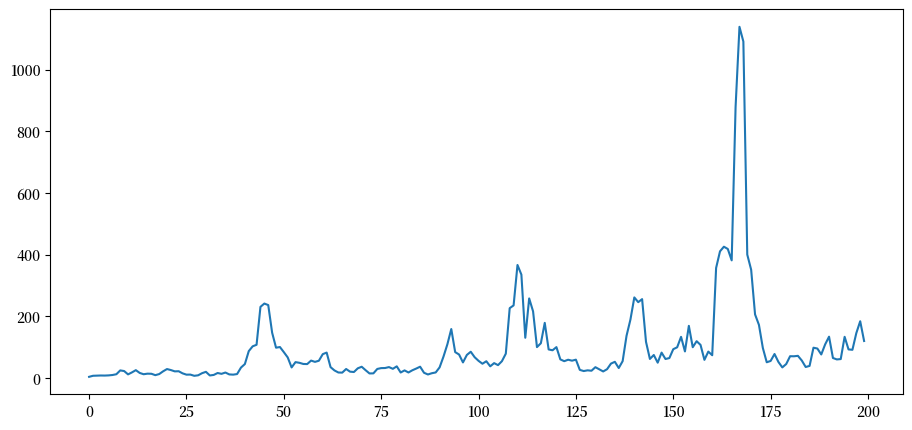

In [12]:
fig, ax = plt.subplots()
ax.plot(w)
plt.show()

注意财富随时间变化的大幅波动。

这种波动类似于我们在{doc}`研究Kesten过程时<kesten_processes>`观察到的时间序列。

### 不平等度量

让我们看看不平等程度如何随金融资产回报率变化。

下面的函数生成一个横截面数据，然后计算洛伦兹曲线和基尼系数。

In [13]:
def generate_lorenz_and_gini(wdy, num_households=100_000, T=500):
    """
    通过将num_households个家庭向前模拟到时间T，生成与WealthDynamics模型
    相对应的洛伦兹曲线数据和基尼系数。
    """
    ψ_0 = np.full(num_households, wdy.y_mean)
    z_0 = wdy.z_mean

    ψ_star = update_cross_section(wdy, ψ_0, shift_length=T)
    return qe.gini_coefficient(ψ_star), qe.lorenz_curve(ψ_star)

现在我们研究随着储蓄回报率的变化，财富分布的洛伦兹曲线如何变化。

下面的代码绘制了三个不同 $\mu_r$ 值对应的洛伦兹曲线。

如果你自己运行这段代码，请注意它需要一到两分钟才能执行完成。

这是不可避免的，因为我们正在执行一个CPU密集型任务。

实际上，这段经过JIT编译和并行化处理的代码相对于计算量来说运行速度已经非常快了。

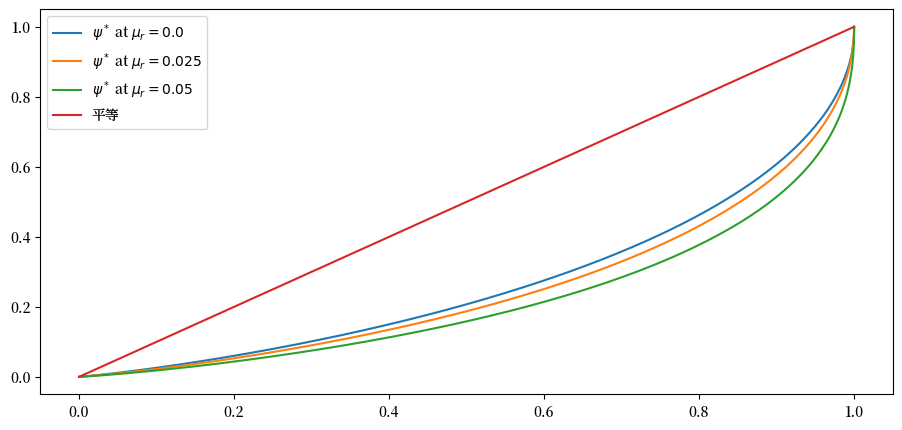

CPU times: user 51.3 s, sys: 82.1 ms, total: 51.4 s
Wall time: 13.6 s


In [14]:
%%time

fig, ax = plt.subplots()
μ_r_vals = (0.0, 0.025, 0.05)
gini_vals = []

for μ_r in μ_r_vals:
    wdy = WealthDynamics(μ_r=μ_r)
    gv, (f_vals, l_vals) = generate_lorenz_and_gini(wdy)
    ax.plot(f_vals, l_vals, label=fr'$\psi^*$ at $\mu_r = {μ_r:0.2}$')
    gini_vals.append(gv)

ax.plot(f_vals, f_vals, label='平等')
ax.legend(loc="upper left")
plt.show()

随着金融收入回报的增加，洛伦兹曲线向下移动，表明不平等程度上升。

我们将通过下面的基尼系数再次研究这一点，但首先请看看上述代码执行时系统资源的以下图像：

由于代码经过高效的JIT编译并完全并行化，如果不更改硬件，几乎不可能让这些任务序列运行得更快。

现在让我们看一看基尼系数。

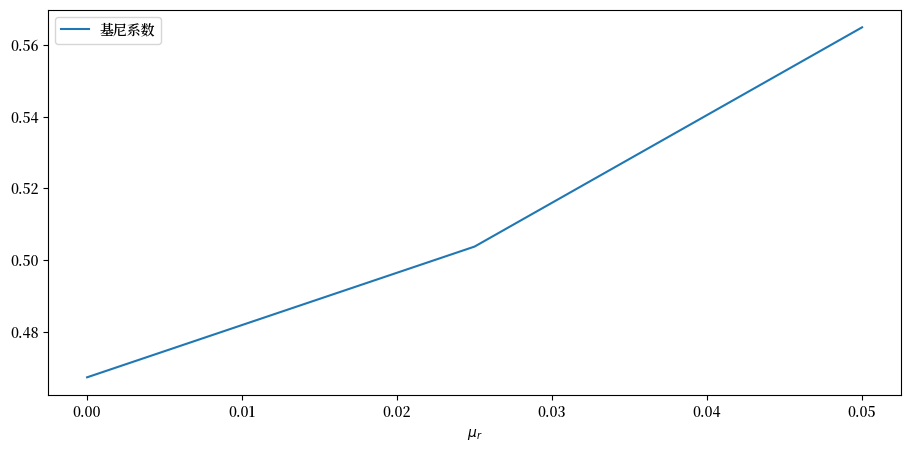

In [15]:
fig, ax = plt.subplots()
ax.plot(μ_r_vals, gini_vals, label='基尼系数')
ax.set_xlabel(r"$\mu_r$")
ax.legend()
plt.show()

我们再次看到，随着金融收入回报的增加，不平等程度也在上升。

最后，让我们通过研究改变金融回报的波动率项$\sigma_r$时会发生什么。

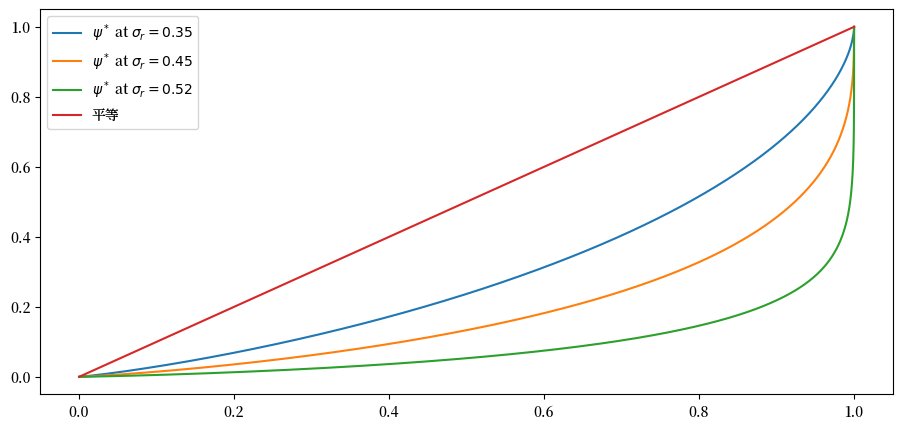

CPU times: user 50.8 s, sys: 26.2 ms, total: 50.8 s
Wall time: 13.1 s


In [16]:
%%time

fig, ax = plt.subplots()
σ_r_vals = (0.35, 0.45, 0.52)
gini_vals = []

for σ_r in σ_r_vals:
    wdy = WealthDynamics(σ_r=σ_r)
    gv, (f_vals, l_vals) = generate_lorenz_and_gini(wdy)
    ax.plot(f_vals, l_vals, label=fr'$\psi^*$ at $\sigma_r = {σ_r:0.2}$')
    gini_vals.append(gv)

ax.plot(f_vals, f_vals, label='平等')
ax.legend(loc="upper left")
plt.show()

我们看到在这个模型中，更大的波动性会导致不平等程度的增加。

## 练习

```{exercise}
:label: wd_ex1

对于具有帕累托尾部的财富或收入分布，更高的尾部指数表明不平等程度更低。

事实上，可以证明帕累托分布的基尼系数，当尾部指数为$a$时，等于$1/(2a - 1)$。

请尽可能通过代码模拟来验证这一点。

具体来说，绘制一个图表，同时使用上述理论值和通过`qe.gini_coefficient`从样本中计算得出的值，来展示基尼系数与尾部指数的关系。

对于尾部指数的值，使用`a_vals = np.linspace(1, 10, 25)`。

对于每个$a$，使用1,000个样本，并采用在讨论帕累托分布的洛伦兹曲线时使用的采样方法来生成帕累托分布的随机数。

请尽可能解释基尼指数与$a$之间的单调关系。
```

```{solution-start} wd_ex1
:class: dropdown
```

这是一个解法，它在理论和模拟之间产生了很好的匹配。

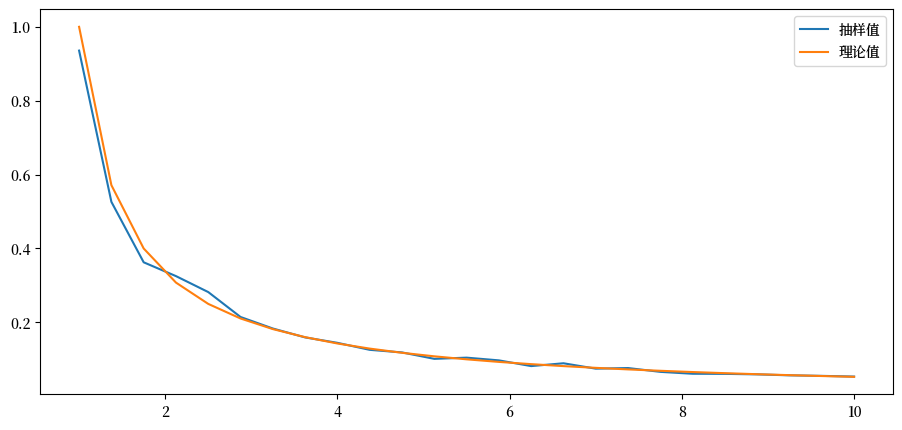

In [17]:
a_vals = np.linspace(1, 10, 25)  # 帕累托尾部指数
ginis = np.empty_like(a_vals)

n = 1000                         # 每个样本的大小
fig, ax = plt.subplots()
for i, a in enumerate(a_vals):
    y = np.random.uniform(size=n)**(-1/a)
    ginis[i] = qe.gini_coefficient(y)
ax.plot(a_vals, ginis, label='抽样值')
ax.plot(a_vals, 1/(2*a_vals - 1), label='理论值')
ax.legend()
plt.show()

一般来说，对于帕累托分布，较高的尾部指数意味着右尾的权重较小。

这意味着财富的极端值较少，因此更加平等。

更大程度的平等转化为更低的基尼系数。

```{solution-end}
```

```{exercise-start}
:label: wd_ex2
```

{eq}`wealth_dynam_ah`中介绍的财富过程类似于{doc}`Kesten过程<kesten_processes>`。

这是因为，根据{eq}`sav_ah`，在所有高于$\hat w$的财富水平上，储蓄是恒定的。

当储蓄恒定时，财富过程具有与Kesten过程相同的准线性结构，包含乘性和加性冲击。

Kesten-Goldie定理告诉我们，在一系列参数化条件下，Kesten过程具有帕累托尾部。

该定理在这里并不直接适用，因为储蓄并不总是恒定的，并且{eq}`wealth_dynam_ah`中的乘性和加性项不是独立同分布的。

同时，考虑到这些相似性，也许会出现帕累托尾部。

要测试这一点，运行一个生成财富横截面的模拟，并生成一个等级-规模图。

如果你愿意，可以使用`quantecon`库中的`rank_size`函数（文档在[这里](https://quanteconpy.readthedocs.io/en/latest/tools/inequality.html#quantecon.inequality.rank_size)）。

在查看图表时，请记住帕累托尾部会生成一条直线。你看到的是这样吗？

对于样本大小和初始条件，使用

In [18]:
num_households = 250_000
T = 500                                      # 向前移动T个周期
ψ_0 = np.full(num_households, wdy.y_mean)   # 初始分布
z_0 = wdy.z_mean

```{exercise-end}
```

```{solution-start} wd_ex2
:class: dropdown
```

首先让我们生成分布:

In [19]:
num_households = 250_000
T = 500  # 向前移动的时间长度
wdy = WealthDynamics()
ψ_0 = np.full(num_households, wdy.y_mean)
z_0 = wdy.z_mean

ψ_star = update_cross_section(wdy, ψ_0, shift_length=T)

现在让我们看看排名-规模图:

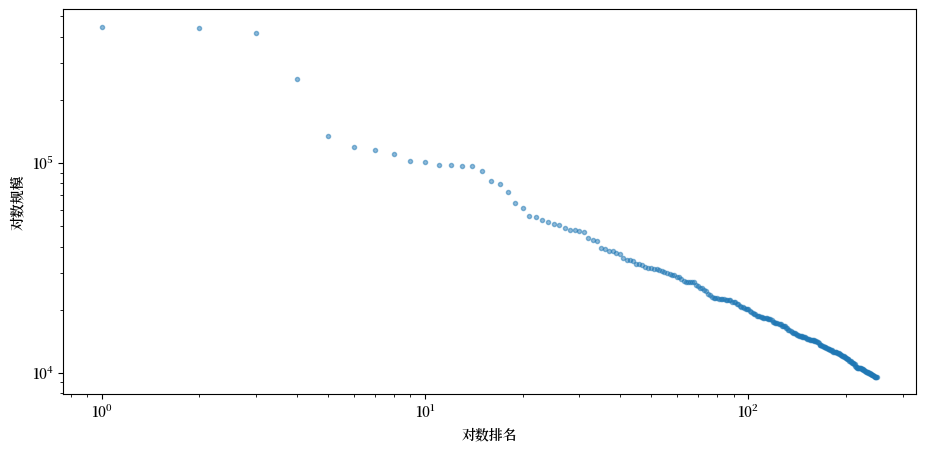

In [20]:
fig, ax = plt.subplots()

rank_data, size_data = qe.rank_size(ψ_star, c=0.001)
ax.loglog(rank_data, size_data, 'o', markersize=3.0, alpha=0.5)
ax.set_xlabel("对数排名")
ax.set_ylabel("对数规模")

plt.show()

```{solution-end}
```